In [1]:
!pip install gdown
!pip install dtaidistance
!pip install fastdtw
!pip install stumpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512552 sha256=7aa279b6426016f754066948a4aa85b0d4e47d4d6a4e6ab44f0ca0948f4c064f
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 5.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import stumpy
from dtaidistance import dtw
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from scipy.stats import median_abs_deviation
from collections import Counter
from statsmodels.tsa.seasonal import seasonal_decompose

bitcoin: https://drive.google.com/file/d/1an5nASu-pNeWXi02Bm4yRcrY_8gj0GF3/view?usp=drive_link

ether: https://drive.google.com/file/d/1AfCIIRDxAP_hG8-us27Anf8CHbmd67yF/view?usp=drive_link

nyt news: https://drive.google.com/file/d/1eEK95-eJCHxVbg6WVRQ1xZC3OtxPjhOS/view?usp=drive_link

# Pré-processamento

In [3]:
#baixando os datasets
!gdown https://drive.google.com/uc?id=1an5nASu-pNeWXi02Bm4yRcrY_8gj0GF3
!gdown https://drive.google.com/uc?id=1AfCIIRDxAP_hG8-us27Anf8CHbmd67yF

#baixando as news
!gdown https://drive.google.com/uc?id=1eEK95-eJCHxVbg6WVRQ1xZC3OtxPjhOS

Downloading...
From: https://drive.google.com/uc?id=1an5nASu-pNeWXi02Bm4yRcrY_8gj0GF3
To: /content/BTC-USD.csv
100% 221k/221k [00:00<00:00, 5.25MB/s]
Downloading...
From: https://drive.google.com/uc?id=1AfCIIRDxAP_hG8-us27Anf8CHbmd67yF
To: /content/ETH-USD.csv
100% 126k/126k [00:00<00:00, 3.08MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1eEK95-eJCHxVbg6WVRQ1xZC3OtxPjhOS
From (redirected): https://drive.google.com/uc?id=1eEK95-eJCHxVbg6WVRQ1xZC3OtxPjhOS&confirm=t&uuid=16733e5f-29fa-43af-8b9c-5bd620109eae
To: /content/nyt-metadata.csv
100% 4.63G/4.63G [00:56<00:00, 81.3MB/s]


In [4]:
#lendo os datasets das series temporais
df_bit = pd.read_csv('BTC-USD.csv')
df_eth = pd.read_csv('ETH-USD.csv')

In [5]:
df_bit.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [6]:
df_eth.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984


In [7]:
#filtrando o range de datas selecionado
df_bit['Date'] = pd.to_datetime(df_bit['Date'])

df_bitcoin = df_bit[df_bit['Date'] >= '2019-01-01'].reset_index(drop=True)

df_bitcoin

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4324200990
1,2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5244856836
2,2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4530215219
3,2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4847965467
4,2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5137609824
...,...,...,...,...,...,...,...
1141,2022-02-15,42586.464844,44667.218750,42491.035156,44575.203125,44575.203125,22721659051
1142,2022-02-16,44578.277344,44578.277344,43456.691406,43961.859375,43961.859375,19792547657
1143,2022-02-17,43937.070313,44132.972656,40249.371094,40538.011719,40538.011719,26246662813
1144,2022-02-18,40552.132813,40929.152344,39637.617188,40030.976563,40030.976563,23310007704


In [8]:
#filtrando o range de datas selecionado
df_eth['Date'] = pd.to_datetime(df_eth['Date'])

df_ether = df_eth[(df_eth['Date'] >= '2019-01-01') & (df_eth['Date'] <= '2022-02-19')].reset_index(drop=True)

df_ether

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-01,133.418152,141.397507,132.650711,140.819412,140.819412,2258709868
1,2019-01-02,141.519516,156.929138,140.650955,155.047684,155.047684,3328240369
2,2019-01-03,155.196045,155.863052,147.198364,149.135010,149.135010,2676164880
3,2019-01-04,148.912888,156.878983,147.907104,154.581940,154.581940,3126192535
4,2019-01-05,154.337418,160.824890,154.337418,155.638596,155.638596,3338211928
...,...,...,...,...,...,...,...
1141,2022-02-15,2933.729004,3185.520752,2917.857178,3179.877197,3179.877197,13921257873
1142,2022-02-16,3180.446777,3181.616943,3055.168213,3127.830078,3127.830078,12352406833
1143,2022-02-17,3126.858398,3154.615234,2861.852051,2881.481934,2881.481934,15860206214
1144,2022-02-18,2884.340576,2937.308594,2761.643311,2785.727539,2785.727539,15748173433


In [9]:
#mantendo apenas os dados de date e high do dataset
df_bitcoin.drop(['Open', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True)
df_ether.drop(['Open', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True)

In [10]:
df_bitcoin.head()

,Date,High
0,2019-01-01,3850.913818
1,2019-01-02,3947.981201
2,2019-01-03,3935.685059
3,2019-01-04,3865.934570
4,2019-01-05,3904.903076


In [11]:
df_ether.head()

,Date,High
0,2019-01-01,141.397507
1,2019-01-02,156.929138
2,2019-01-03,155.863052
3,2019-01-04,156.878983
4,2019-01-05,160.824890


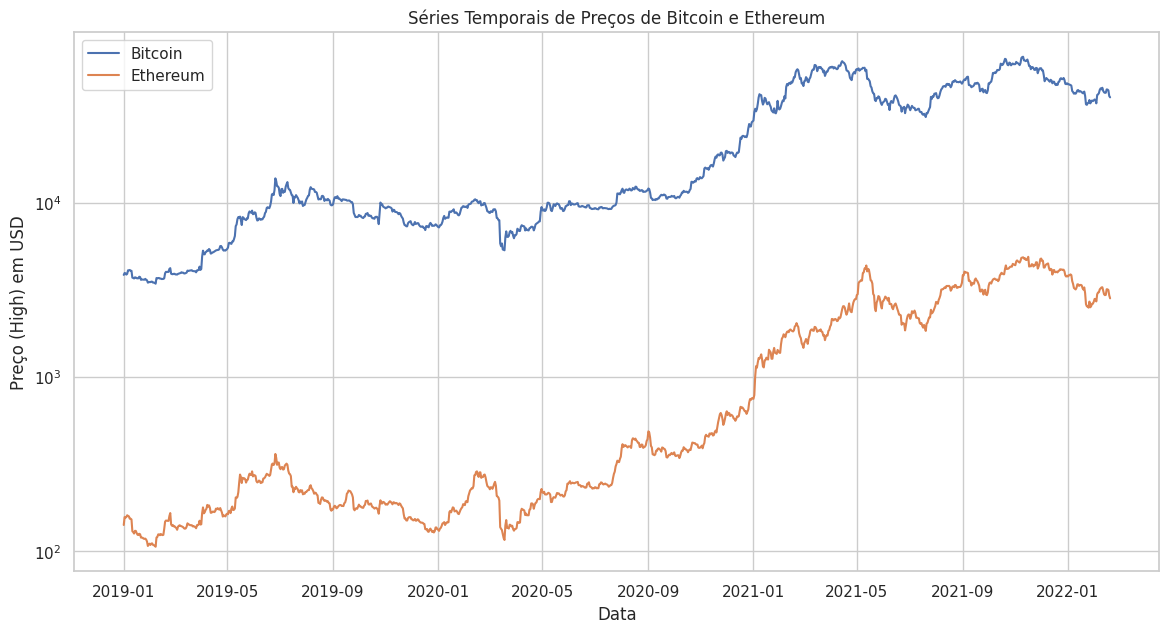

In [12]:
sns.set(style="whitegrid")


plt.figure(figsize=(14, 7))
sns.lineplot(data=df_bitcoin, x='Date', y='High', label='Bitcoin')
sns.lineplot(data=df_ether, x='Date', y='High', label='Ethereum')
plt.yscale('log')  # Escala logarítmica no eixo y pra conseguirmos enxergar melhor as variações do ethereum
plt.title('Séries Temporais de Preços de Bitcoin e Ethereum')
plt.xlabel('Data')
plt.ylabel('Preço (High) em USD')
plt.legend()

# Exibe o gráfico
plt.show()


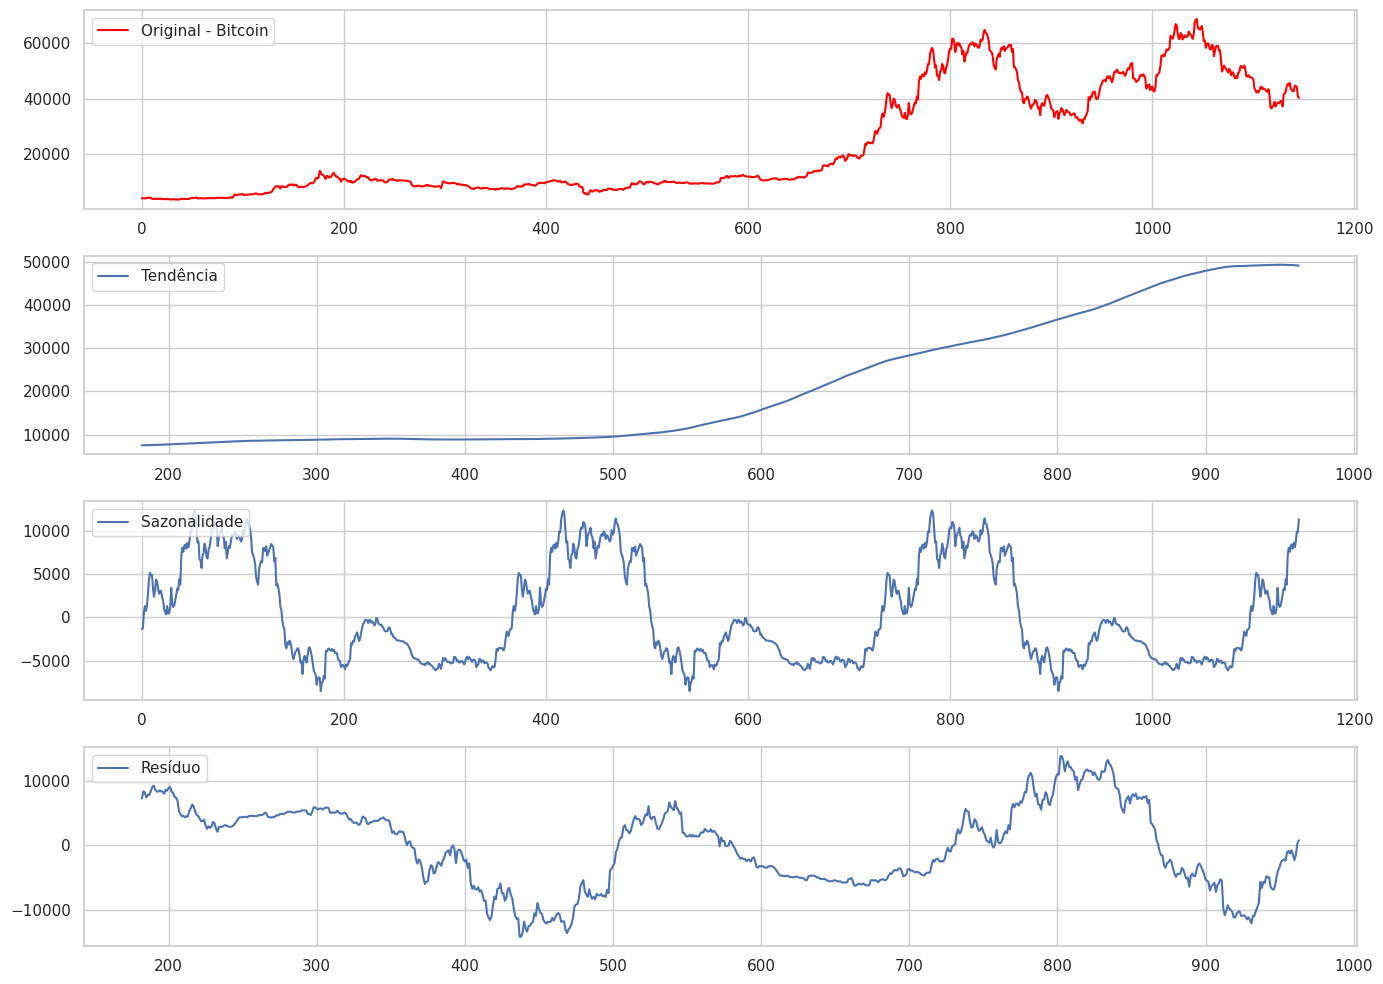

In [13]:
#plotando a serie, tendência, sazonalidade e residuo
series = df_bitcoin['High']

result = seasonal_decompose(series, model='additive', period=365)

plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(series, color = 'red', label='Original - Bitcoin')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Tendência')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Sazonalidade')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Resíduo')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

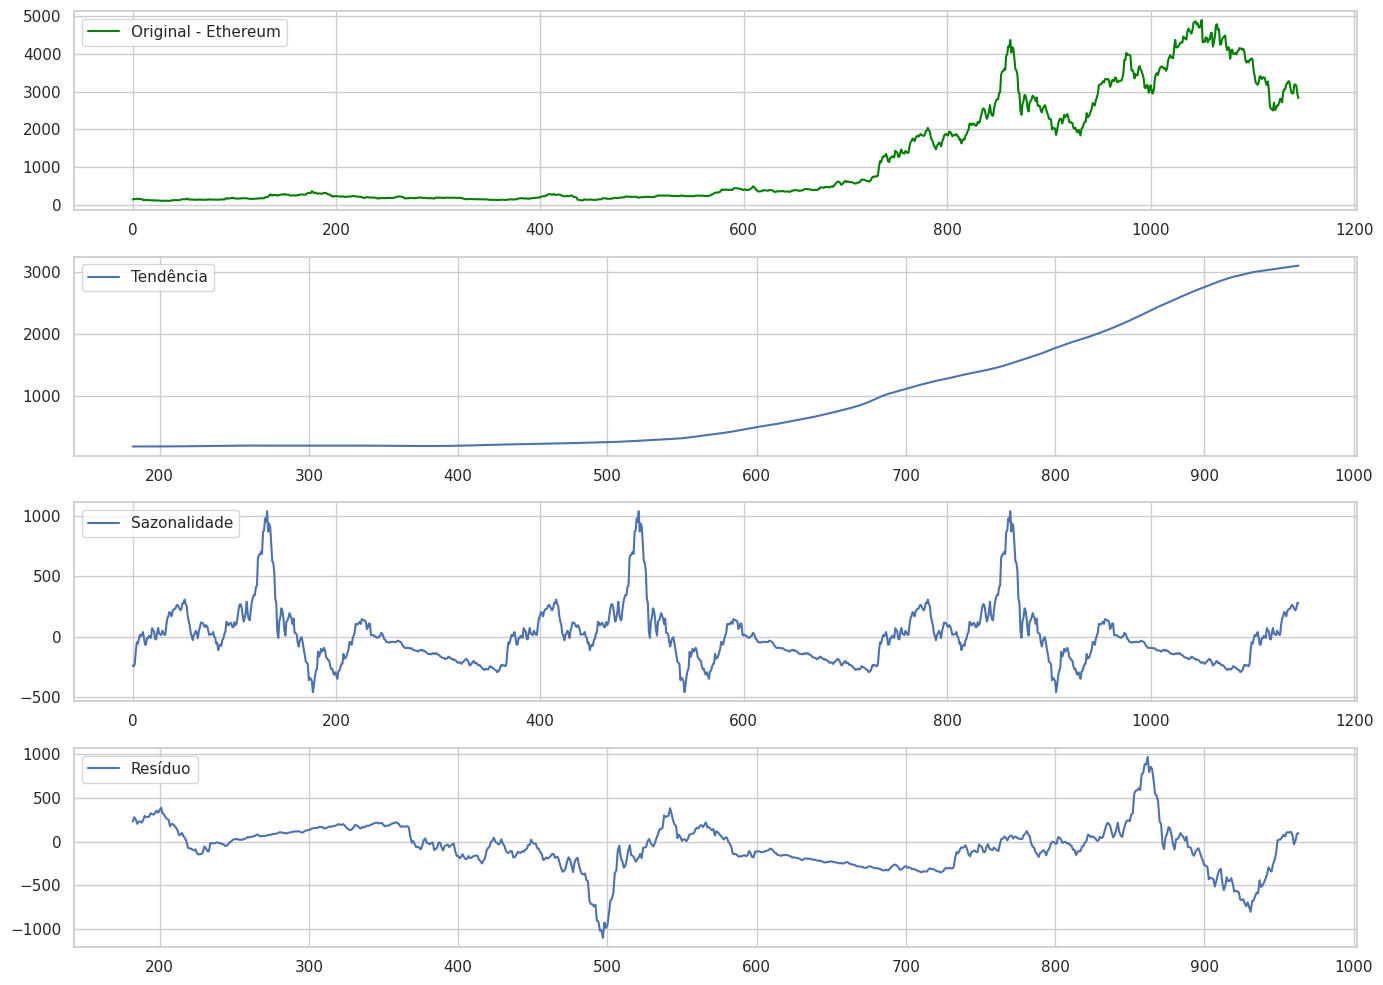

In [14]:
#plotando a serie, tendência, sazonalidade e residuo
series = df_ether['High']

result = seasonal_decompose(series, model='additive', period=365)

plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(series, color = 'green', label='Original - Ethereum')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Tendência')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Sazonalidade')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Resíduo')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [15]:
# Calculando a média e o desvio padrão
mean_bitcoin = df_bitcoin['High'].mean()
std_bitcoin = df_bitcoin['High'].std()

mean_ether = df_ether['High'].mean()
std_ether = df_ether['High'].std()

# z-noralizando manualmente
df_bitcoin['High_z'] = (df_bitcoin['High'] - mean_bitcoin) / std_bitcoin
df_ether['High_z'] = (df_ether['High'] - mean_ether) / std_ether

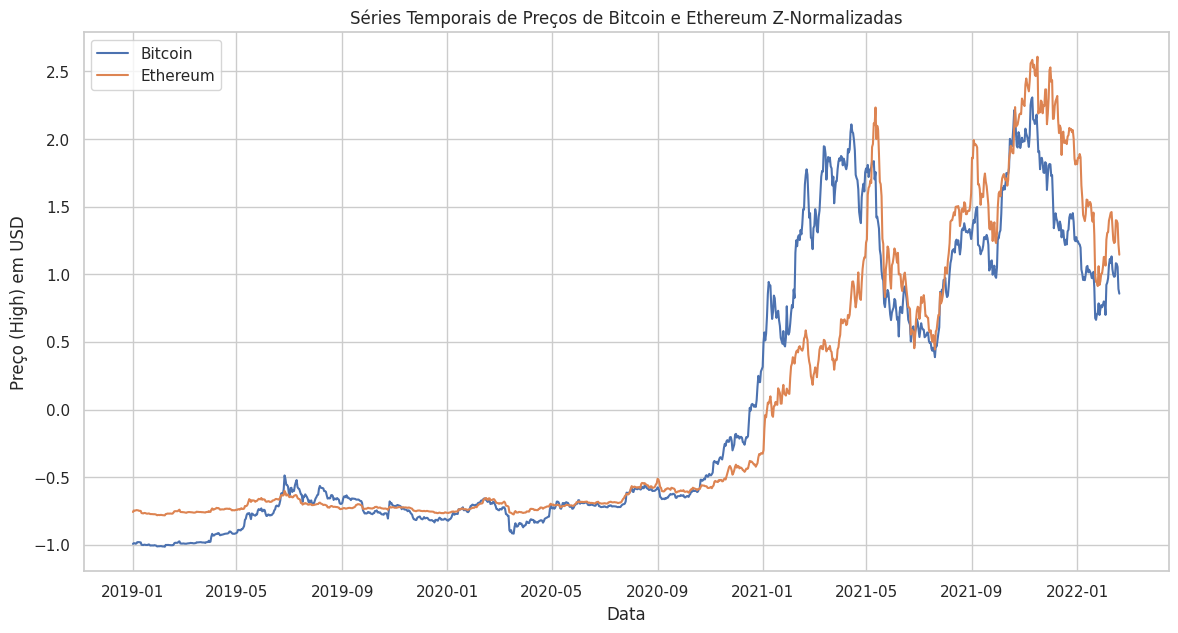

In [16]:
sns.set(style="whitegrid")

plt.figure(figsize=(14, 7))
sns.lineplot(data=df_bitcoin, x='Date', y='High_z', label='Bitcoin')
sns.lineplot(data=df_ether, x='Date', y='High_z', label='Ethereum')
plt.title('Séries Temporais de Preços de Bitcoin e Ethereum Z-Normalizadas')
plt.xlabel('Data')
plt.ylabel('Preço (High) em USD')
plt.legend()

# Exibe o gráfico
plt.show()

In [17]:
ts_ethereum_norm = df_ether['High_z']
ts_bitcoin_norm = df_bitcoin['High_z']

In [18]:
#Removendo a tendência da série temporal do Ethereum
decomposition = seasonal_decompose(ts_ethereum_norm, model='additive', period=365)
ts_ethereum_norm_detrended = ts_ethereum_norm - decomposition.trend
ts_ethereum_norm_detrended = ts_ethereum_norm_detrended.bfill()
ts_ethereum_norm_detrended = ts_ethereum_norm_detrended.ffill()

In [19]:
#Removendo a tendência da série temporal do Bitcoin
decomposition = seasonal_decompose(ts_bitcoin_norm, model='additive', period=365)
ts_bitcoin_norm_detrended = ts_bitcoin_norm - decomposition.trend
ts_bitcoin_norm_detrended = ts_bitcoin_norm_detrended.bfill()
ts_bitcoin_norm_detrended = ts_bitcoin_norm_detrended.ffill()

In [20]:
df_bitcoin['High_z_detrended'] = ts_bitcoin_norm_detrended
df_ether['High_z_detrended'] = ts_ethereum_norm_detrended

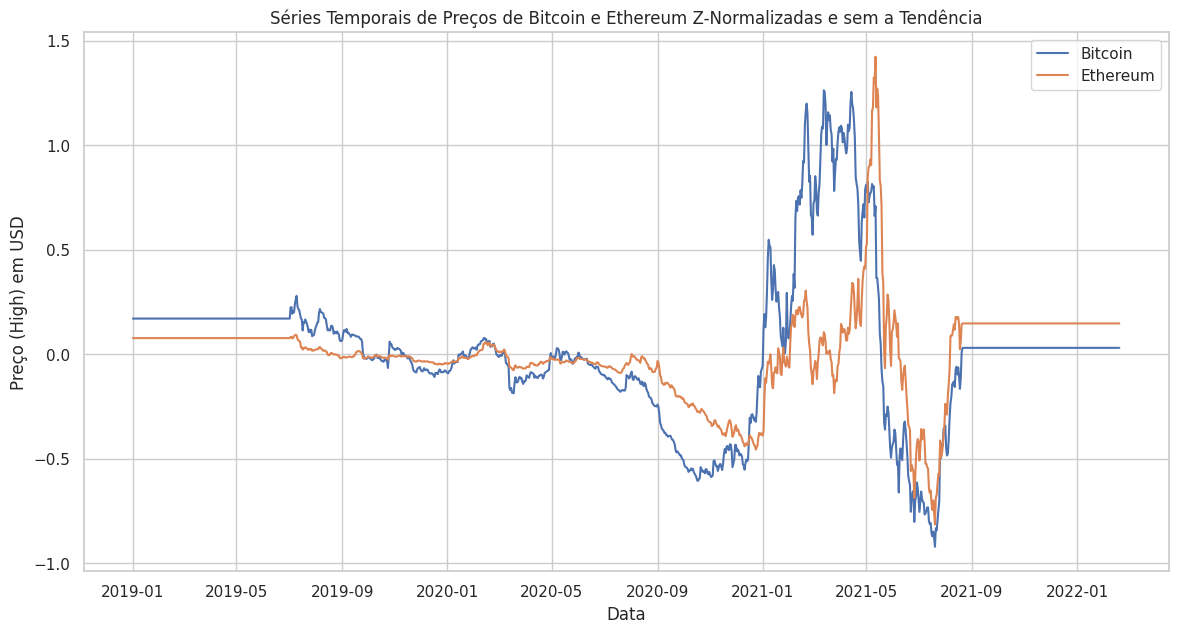

In [21]:
sns.set(style="whitegrid")

plt.figure(figsize=(14, 7))
sns.lineplot(data=df_bitcoin, x='Date', y='High_z_detrended', label='Bitcoin')
sns.lineplot(data=df_ether, x='Date', y='High_z_detrended', label='Ethereum')
plt.title('Séries Temporais de Preços de Bitcoin e Ethereum Z-Normalizadas e sem a Tendência')
plt.xlabel('Data')
plt.ylabel('Preço (High) em USD')
plt.legend()

# Exibe o gráfico
plt.show()

#DTW

###Funções Comuns

In [22]:
# Função para calcular DTW entre duas subsequencias
def calculate_dtw_distance(seq1, seq2):
    distance, path = fastdtw(seq1, seq2, dist=2)

    return distance, path

In [23]:
# Função para calcular o DTW entre todas as subsequências da série temporal
def calculate_all_dtw_distances(serie_temporal, window_size):
    num_windows = len(serie_temporal) // window_size
    distances = []

    for i in range(num_windows):
        # Seleciona a subsequência atual
        subsequencia_i = serie_temporal[i * window_size : (i + 1) * window_size]

        # Comparar com todas as outras subsequências
        for j in range(i + 1, num_windows):
            subsequencia_j = serie_temporal[j * window_size : (j + 1) * window_size]
            distance, path = calculate_dtw_distance(subsequencia_i, subsequencia_j)
            distances.append({
                "first_window_comparison": i,
                "second_window_comparison": j,
                "distance": distance
            })

    return distances

In [24]:
#função para identificar
def identify_anomalies(distances):
    distances_only = [d["distance"] for d in distances]
    threshold = np.mean(distances_only) + 3 * np.std(distances_only) #threshold baseado em media e desvio padrão

    outliers = [d for d in distances if d["distance"] > threshold] #distancias acima do threshold são consideradas outliers

    count_first = Counter([a["first_window_comparison"] for a in outliers])
    count_second = Counter([a["second_window_comparison"] for a in outliers])

    total_count = count_first + count_second #contando quantas vezes uma mesma janela foi identificada como outlier
    mean_ocurrs = np.mean(list(total_count.values()))

    return [win for win, ocurrs in total_count.items() if ocurrs >= mean_ocurrs] #se a janela aparece uma quantidade de vezes maior que a média como outlier é considerado anomalia

In [25]:
def plot_anomalies(df, window_size, anomaly_windows, coin):
    sns.set(style="whitegrid")

    # Plotando a série temporal com as anomalias destacadas
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=df, x='Date', y='High_z_detrended', label=coin)
    plt.title(f'Detecção de Anomalias na Série Temporal do Preço do {coin} Z-Normalizada e sem Tendência')
    plt.xlabel('Data')
    plt.ylabel('Preço (High) em USD')

    # Destacando regiões anômalas
    for a in anomaly_windows:
        plt.axvspan(df['Date'].iloc[a * window_size],
                    df['Date'].iloc[a * window_size + window_size - 1],
                    color="red", alpha=0.3)

    plt.legend()
    plt.show()

In [26]:
#função que identifica as datas relacionadas às janelas detectadas como anômalas
def find_anomaly_dates(df, window_size, anomaly_windows):
    return [(df['Date'].iloc[a * window_size], df['Date'].iloc[a * window_size + window_size - 1]) for a in anomaly_windows]

###Ethereum

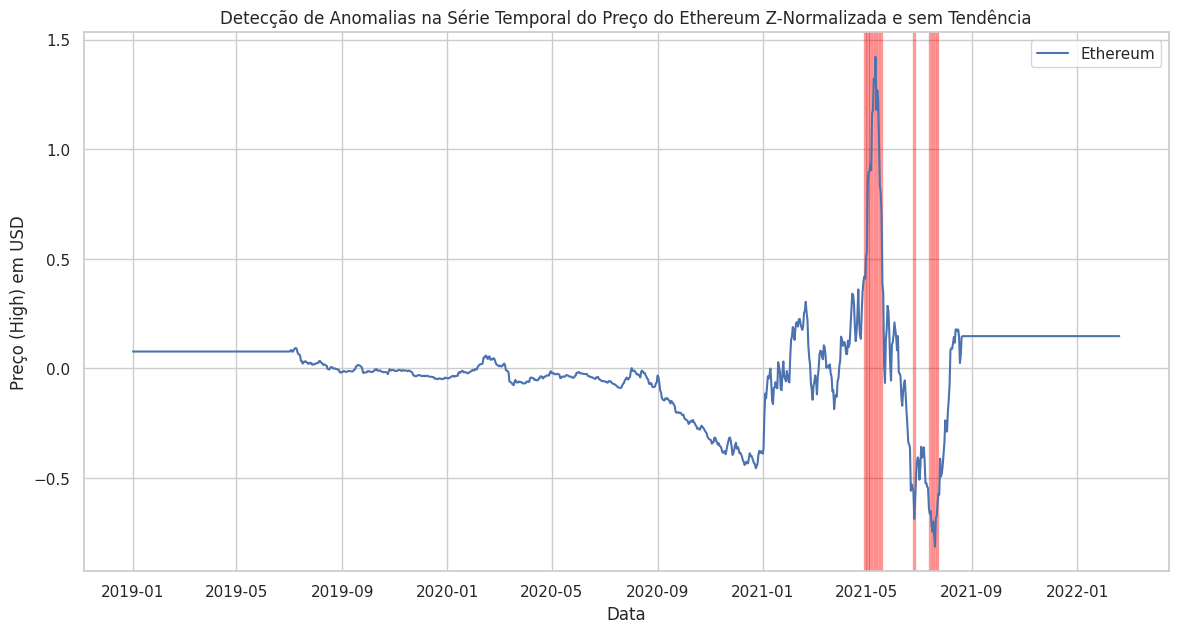


Anomalias encontradas: 
Entre 29/04/2021 e 01/05/2021
Entre 02/05/2021 e 04/05/2021
Entre 05/05/2021 e 07/05/2021
Entre 08/05/2021 e 10/05/2021
Entre 11/05/2021 e 13/05/2021
Entre 14/05/2021 e 16/05/2021
Entre 17/05/2021 e 19/05/2021
Entre 19/07/2021 e 21/07/2021
Entre 16/07/2021 e 18/07/2021
Entre 13/07/2021 e 15/07/2021
Entre 25/06/2021 e 27/06/2021
Entre 22/07/2021 e 24/07/2021


12

In [27]:
window_size = 3

distances = calculate_all_dtw_distances(ts_ethereum_norm_detrended, window_size)
anomalies_windows = identify_anomalies(distances)

plot_anomalies(df_ether, window_size, anomalies_windows, "Ethereum")

anomalies_periods = find_anomaly_dates(df_ether, window_size, anomalies_windows)

print("\nAnomalias encontradas: ")
for start_date, end_date in anomalies_periods:
    print(f"Entre {start_date.strftime('%d/%m/%Y')} e {end_date.strftime('%d/%m/%Y')}")

len(anomalies_periods)

###Bitcoin

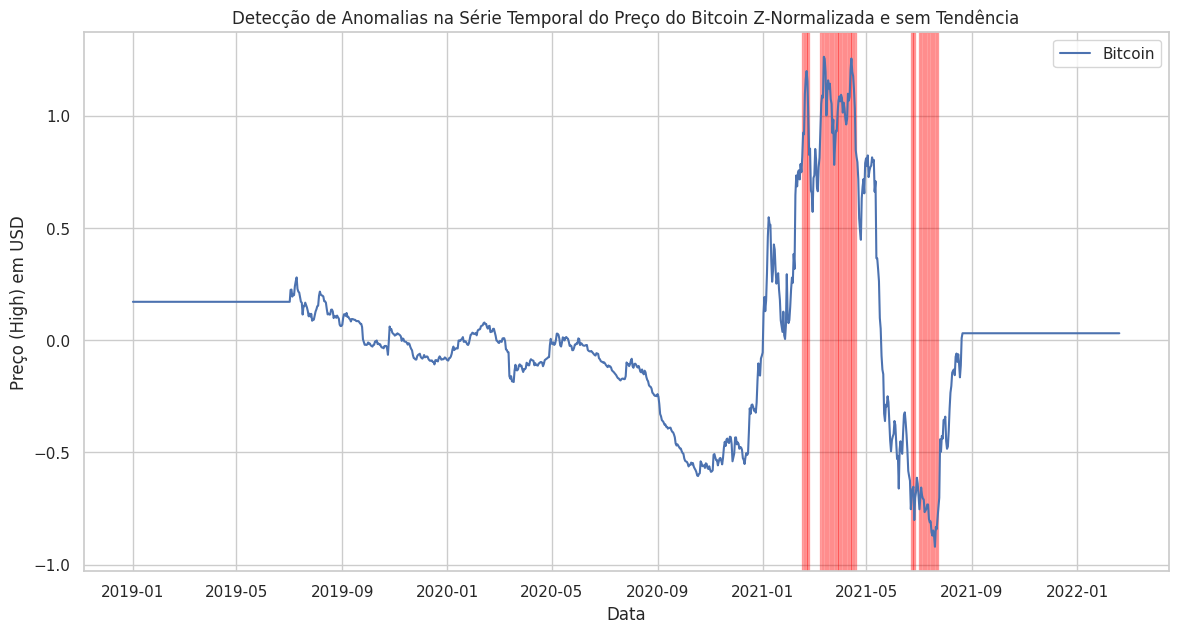


Anomalias encontradas: 
Entre 16/02/2021 e 18/02/2021
Entre 19/02/2021 e 21/02/2021
Entre 22/02/2021 e 24/02/2021
Entre 09/03/2021 e 11/03/2021
Entre 12/03/2021 e 14/03/2021
Entre 15/03/2021 e 17/03/2021
Entre 18/03/2021 e 20/03/2021
Entre 21/03/2021 e 23/03/2021
Entre 24/03/2021 e 26/03/2021
Entre 27/03/2021 e 29/03/2021
Entre 30/03/2021 e 01/04/2021
Entre 02/04/2021 e 04/04/2021
Entre 05/04/2021 e 07/04/2021
Entre 08/04/2021 e 10/04/2021
Entre 11/04/2021 e 13/04/2021
Entre 14/04/2021 e 16/04/2021
Entre 17/04/2021 e 19/04/2021
Entre 16/07/2021 e 18/07/2021
Entre 19/07/2021 e 21/07/2021
Entre 22/06/2021 e 24/06/2021
Entre 25/06/2021 e 27/06/2021
Entre 01/07/2021 e 03/07/2021
Entre 07/07/2021 e 09/07/2021
Entre 10/07/2021 e 12/07/2021
Entre 13/07/2021 e 15/07/2021
Entre 22/07/2021 e 24/07/2021
Entre 04/07/2021 e 06/07/2021


27

In [28]:
window_size = 3

distances = calculate_all_dtw_distances(ts_bitcoin_norm_detrended, window_size)
anomalies_windows = identify_anomalies(distances)

plot_anomalies(df_bitcoin, window_size, anomalies_windows, "Bitcoin")

anomalies_periods2 = find_anomaly_dates(df_bitcoin, window_size, anomalies_windows)

print("\nAnomalias encontradas: ")
for start_date, end_date in anomalies_periods2:
    print(f"Entre {start_date.strftime('%d/%m/%Y')} e {end_date.strftime('%d/%m/%Y')}")

len(anomalies_periods2)

#Matrix Profile

In [29]:
ETR_series = ts_ethereum_norm_detrended
BC_series = ts_bitcoin_norm_detrended

In [30]:
#Agrupa as anomalias em janelas
def group_anomalies(indices, gap=1):
    if len(indices) == 0:
        return []

    windows = []
    start = indices[0]
    for i in range(1, len(indices)):
        if indices[i] > indices[i - 1] + gap:
            windows.append((start, indices[i - 1]))
            start = indices[i]
    windows.append((start, indices[-1]))
    return windows

In [31]:
def plot_anomalies_MP(df, window_size, anomaly_windows, coin):
    sns.set(style="whitegrid")

    plt.figure(figsize=(14, 7))
    sns.lineplot(data=df, x='Date', y='High_z_detrended', label=coin)
    plt.title(f'Detecção de Anomalias na Série Temporal do Preço do {coin} Z-Normalizada e sem Tendência')
    plt.xlabel('Data')
    plt.ylabel('Preço (High) em USD')

    for start, end in anomaly_windows:
      plt.axvspan(df['Date'].iloc[start], df['Date'].iloc[end + window_size - 1],
                  color="red", alpha=0.3)

    format = '%d/%m/%Y'
    for start_idx, end_idx in anomaly_windows:
      start_date = df['Date'].iloc[start_idx]
      end_date = df['Date'].iloc[end_idx + window_size - 1]
      print(f'From {start_date.strftime(format)} to {end_date.strftime(format)}')

##Ethereum

Total de anomalias detectadas: 35
From 26/07/2019 to 28/07/2019
From 12/10/2019 to 14/10/2019
From 25/10/2019 to 27/10/2019
From 04/12/2019 to 06/12/2019
From 22/12/2019 to 24/12/2019
From 25/12/2019 to 27/12/2019
From 08/01/2020 to 10/01/2020
From 31/01/2020 to 02/02/2020
From 29/02/2020 to 02/03/2020
From 20/04/2020 to 22/04/2020
From 05/05/2020 to 07/05/2020
From 25/05/2020 to 27/05/2020
From 30/05/2020 to 01/06/2020
From 01/06/2020 to 03/06/2020
From 08/06/2020 to 10/06/2020
From 26/07/2020 to 28/07/2020
From 13/08/2020 to 15/08/2020
From 09/09/2020 to 11/09/2020
From 10/09/2020 to 12/09/2020
From 22/09/2020 to 24/09/2020
From 29/09/2020 to 01/10/2020
From 10/10/2020 to 12/10/2020
From 11/10/2020 to 13/10/2020
From 19/10/2020 to 21/10/2020
From 05/12/2020 to 07/12/2020
From 12/12/2020 to 14/12/2020
From 16/12/2020 to 18/12/2020
From 27/12/2020 to 29/12/2020
From 28/12/2020 to 30/12/2020
From 31/12/2020 to 02/01/2021
From 10/04/2021 to 12/04/2021
From 12/05/2021 to 14/05/2021
From 1

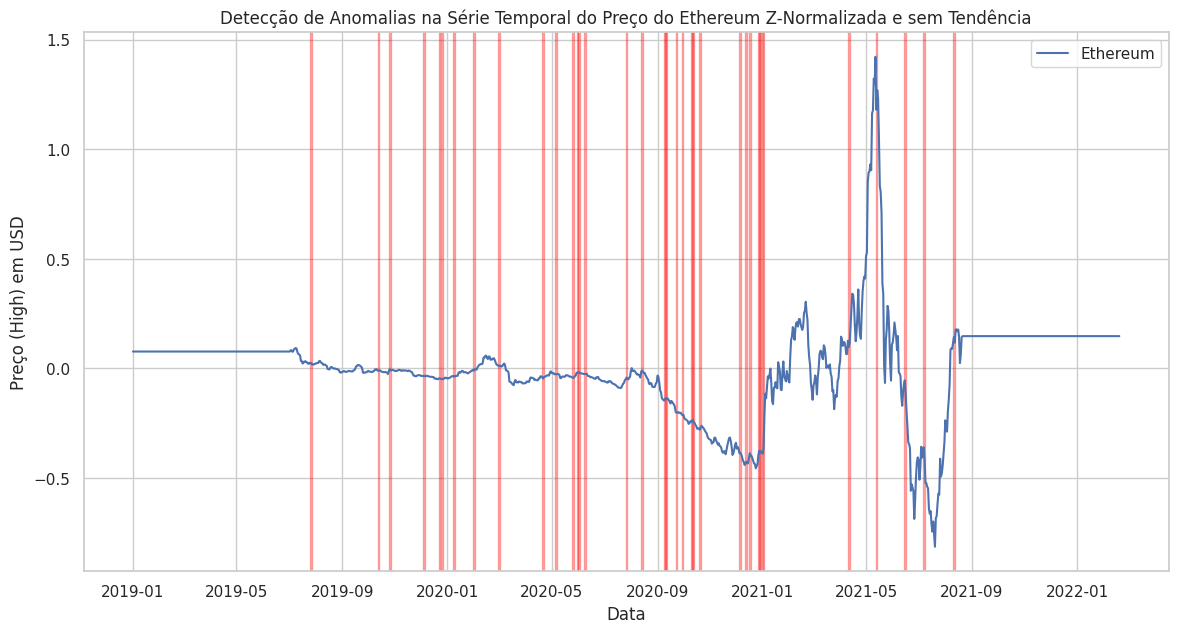

In [40]:
# Computando a matrix profile
window_size = 3
matrix_profile = stumpy.stump(ETR_series, m=window_size)
profile_values = matrix_profile[:, 0]

# Detectando anomalias com base em um threshold
threshold = np.percentile(profile_values, 97)
anomalies = np.where(profile_values > threshold)[0]

# Obtendo as janelas anômalas
anomalies_windows = group_anomalies(anomalies, gap=0)
print(f"Total de anomalias detectadas: {len(anomalies_windows)}")
plot_anomalies_MP(df_ether, window_size, anomalies_windows, 'Ethereum')

plt.show()

##Bitcoin

Total de anomalias detectadas: 35
From 04/07/2019 to 06/07/2019
From 25/07/2019 to 27/07/2019
From 15/08/2019 to 17/08/2019
From 05/09/2019 to 07/09/2019
From 12/10/2019 to 14/10/2019
From 23/10/2019 to 25/10/2019
From 03/11/2019 to 05/11/2019
From 04/12/2019 to 06/12/2019
From 24/12/2019 to 26/12/2019
From 07/01/2020 to 09/01/2020
From 28/01/2020 to 30/01/2020
From 20/02/2020 to 22/02/2020
From 13/03/2020 to 15/03/2020
From 14/03/2020 to 16/03/2020
From 24/03/2020 to 26/03/2020
From 28/03/2020 to 30/03/2020
From 11/04/2020 to 13/04/2020
From 29/04/2020 to 01/05/2020
From 02/05/2020 to 04/05/2020
From 09/10/2020 to 11/10/2020
From 26/12/2020 to 28/12/2020
From 01/03/2021 to 03/03/2021
From 02/03/2021 to 04/03/2021
From 18/03/2021 to 20/03/2021
From 19/03/2021 to 21/03/2021
From 31/03/2021 to 02/04/2021
From 07/04/2021 to 09/04/2021
From 27/04/2021 to 29/04/2021
From 28/04/2021 to 30/04/2021
From 30/04/2021 to 02/05/2021
From 01/05/2021 to 03/05/2021
From 02/05/2021 to 04/05/2021
From 2

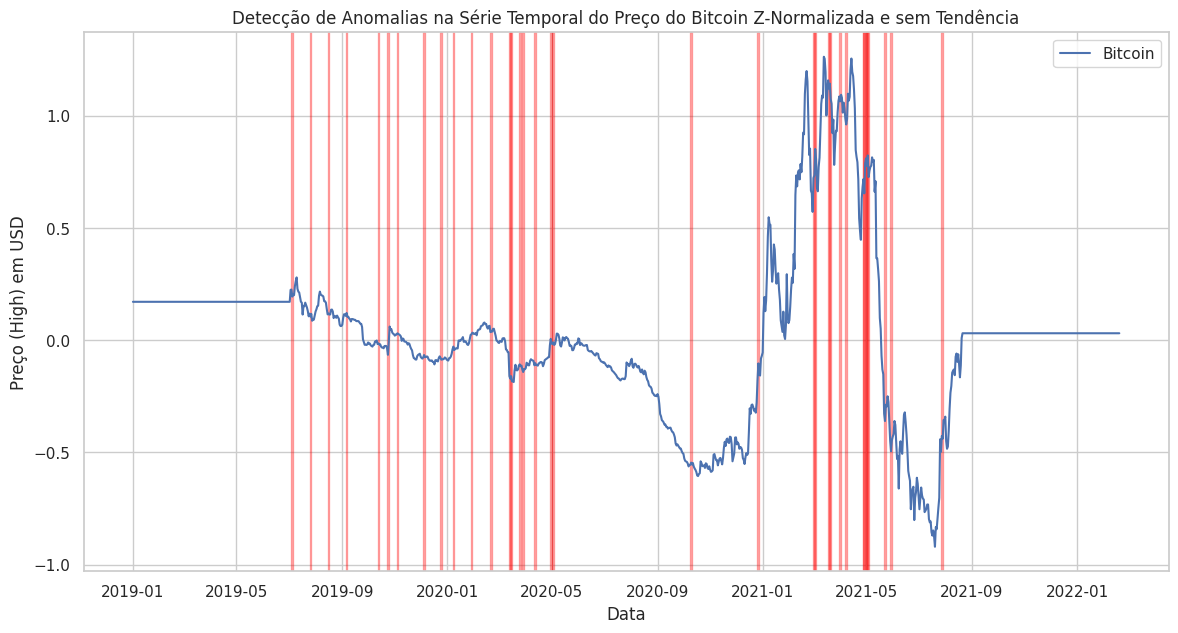

In [39]:
# Computando a matrix profile
window_size = 3
matrix_profile = stumpy.stump(BC_series, m=window_size)
profile_values = matrix_profile[:, 0]

# Detectando anomalias com base em um threshold
threshold = np.percentile(profile_values, 97) # Adaptative threshold
anomalies = np.where(profile_values > threshold)[0]

# Obtendo as janelas anômalas
anomalies_windows = group_anomalies(anomalies, gap=0)
print(f"Total de anomalias detectadas: {len(anomalies_windows)}")
plot_anomalies_MP(df_bitcoin, window_size, anomalies_windows, 'Bitcoin')

plt.show()

#News

In [ ]:
# Carregar o arquivo em um DataFrame
df_news = pd.read_csv('nyt-metadata.csv')


# Exibir as primeiras linhas do DataFrame para verificar
df_news.head()

<ipython-input-36-9fecab822581>:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_news = pd.read_csv('nyt-metadata.csv')


,abstract,web_url,snippet,lead_paragraph,print_section,print_page,source,multimedia,headline,keywords,pub_date,document_type,news_desk,section_name,byline,type_of_material,_id,word_count,uri,subsection_name
0,Article on upcoming New York Giants-Dallas Cow...,https://www.nytimes.com/2000/01/01/sports/pro-...,Article on upcoming New York Giants-Dallas Cow...,Waiting in the visiting locker room at Texas S...,D,2.0,The New York Times,[],"{'main': 'Playoffs or No, Dallas Provides The ...","[{'name': 'organizations', 'value': 'New York ...",2000-01-01 05:00:00+00:00,article,Sports Desk,Sports,"{'original': 'By Bill Pennington', 'person': [...",News,nyt://article/01111a48-3502-5021-8096-bc929379...,819.0,nyt://article/01111a48-3502-5021-8096-bc929379...,NaN
1,Jeanne C Pond letter expresses hope that spiri...,https://www.nytimes.com/2000/01/01/opinion/l-o...,Jeanne C Pond letter expresses hope that spiri...,To the Editor:,A,30.0,The New York Times,[],"{'main': 'On This First Day, a Fanfare for the...","[{'name': 'persons', 'value': 'Pond, Jeanne C'...",2000-01-01 05:00:00+00:00,article,Editorial Desk,Opinion,"{'original': '', 'person': [], 'organization':...",Letter,nyt://article/02328edc-dad1-5eb0-900e-917162e4...,122.0,nyt://article/02328edc-dad1-5eb0-900e-917162e4...,NaN
2,Many experts on Y2K computer problem report th...,https://www.nytimes.com/2000/01/01/us/1-1-00-t...,Many experts on Y2K computer problem report th...,As the world slid nervously yesterday through ...,A,10.0,The New York Times,[],"{'main': ""Internet's Cheering Squad Nervously ...","[{'name': 'subject', 'value': 'Electronic Mail...",2000-01-01 05:00:00+00:00,article,National Desk,U.S.,"{'original': 'By Barnaby J. Feder', 'person': ...",News,nyt://article/02a8f89b-153f-5b84-983c-e328de5b...,761.0,nyt://article/02a8f89b-153f-5b84-983c-e328de5b...,NaN
3,WILL the forces of globalism continue to push ...,https://www.nytimes.com/2000/01/01/news/vision...,NaN,WILL the forces of globalism continue to push ...,E,4.0,The New York Times,[],{'main': 'Economic Thinking Finds a Free Marke...,[],2000-01-01 05:00:00+00:00,article,The Millennium,Archives,"{'original': 'By Floyd Norris', 'person': [{'f...",News,nyt://article/0634d837-97b8-59b5-aa17-f90d1a89...,916.0,nyt://article/0634d837-97b8-59b5-aa17-f90d1a89...,NaN
4,SPECIAL TODAY The Millennium Envisioning th...,https://www.nytimes.com/2000/01/01/nyregion/in...,NaN,SPECIAL TODAY,A,1.0,The New York Times,[],"{'main': 'INSIDE', 'kicker': None, 'content_ki...",[],2000-01-01 05:00:00+00:00,article,Metropolitan Desk,New York,"{'original': '', 'person': [], 'organization':...",Summary,nyt://article/0654cc64-c37f-594d-9290-1ce578cd...,102.0,nyt://article/0654cc64-c37f-594d-9290-1ce578cd...,NaN


In [ ]:
df_news.drop([ 'lead_paragraph', 'print_section', 'print_page', 'source', 'multimedia','headline','keywords','document_type','news_desk','byline','type_of_material','_id','word_count','uri','subsection_name'], axis=1, inplace=True)

In [ ]:
valores_unicos = df_news['section_name'].unique()
print(valores_unicos)

['Sports' 'Opinion' 'U.S.' 'Archives' 'New York' 'Business Day'
 'Technology' 'Arts' 'Books' 'World' 'Theater' 'Education' 'Movies'
 'Travel' 'Style' 'Real Estate' 'Magazine' 'Week in Review' 'Automobiles'
 'Fashion & Style' 'Health' 'Science' 'Job Market' 'Food' 'Home & Garden'
 'T Magazine' 'Giving' 'Obituaries' 'The Learning Network' 'membercenter'
 nan 'Climate' 'Your Money' 'Corrections' 'Homepage' 'readersopinions'
 'Crosswords & Games' 'Editors Picks' 'Great Homes & Destinations'
 'nationchallenged' 'Multimedia/Photos' "Critic's Choice" 'College'
 'timestalks' 'Washington' 'none' 'timesselect' 'Blogs' 'Times Topics'
 'Well' 'nytfrontpage' 'UrbanEye' 'xword' 'Sunday Review' 'Global Home'
 'Public Editor' 'Booming' 'The Upshot' 'Feeds' 'International Home'
 'Times Insider' 'NYT Now' 'Admin' 'Universal' 'Topics' 'Today’s Paper'
 'Podcasts' 'Briefing' 'Watching' 'Smarter Living' 'T Brand'
 'Reader Center' 'Slideshows' 'Guides' 'Lens' 'Open' 'Video'
 'Neediest Cases' 'Parenting' 'The

In [ ]:
# Tentar converter a coluna para datetime, marcando valores inválidos como NaT
df_news['pub_date_converted'] = pd.to_datetime(df_news['pub_date'], errors='coerce')

# printar valores inválidos
invalid_dates = df_news[df_news['pub_date_converted'].isna()]['pub_date']
print("Valores inválidos em 'pub_date':")
print(invalid_dates)

# removendo os valores inválidos
df_news = df_news.dropna(subset=['pub_date_converted']).reset_index(drop=True)

df_news['pub_date'] = df_news['pub_date_converted']
df_news = df_news.drop(columns=['pub_date_converted'])

Valores inválidos em 'pub_date':
2131711       NaN
2131712    Sports
Name: pub_date, dtype: object


In [ ]:
# convertendo 'pub_date' para datetime sem timezone
df_news['pub_date'] = pd.to_datetime(df_news['pub_date']).dt.tz_localize(None)

# filtrando pelo intervalo de datas e valores desejados em 'section_name'
df_news2 = df_news[
    (df_news['pub_date'] >= '2019-01-01') &
    (df_news['pub_date'] <= '2022-02-19') &
    (df_news['section_name'].isin(['World', 'U.S.', 'Universal']))
].reset_index(drop=True)

df_news2

,abstract,web_url,snippet,pub_date,section_name
0,The United States Strategic Command’s tweet al...,https://www.nytimes.com/2018/12/31/us/strategi...,The United States Strategic Command’s tweet al...,2019-01-01 00:36:31,U.S.
1,The television network A Haber broadcast foota...,https://www.nytimes.com/2018/12/31/world/middl...,The television network A Haber broadcast foota...,2019-01-01 00:45:40,World
2,President Emmanuel Macron of France urged his ...,https://www.nytimes.com/2018/12/31/world/europ...,President Emmanuel Macron of France urged his ...,2019-01-01 01:04:01,World
3,"In his New Year’s Day speech, North Korea’s le...",https://www.nytimes.com/2018/12/31/world/asia/...,"In his New Year’s Day speech, North Korea’s le...",2019-01-01 01:44:15,World
4,The Massachusetts senator is forming a preside...,https://www.nytimes.com/2019/01/01/us/politics...,The Massachusetts senator is forming a preside...,2019-01-01 05:18:48,U.S.
...,...,...,...,...,...
50605,The justices agreed to hear the Biden administ...,https://www.nytimes.com/2022/02/18/us/politics...,The justices agreed to hear the Biden administ...,2022-02-18 22:48:12,U.S.
50606,"Carrie Lam, the chief executive, said the vote...",https://www.nytimes.com/2022/02/19/world/asia/...,"Carrie Lam, the chief executive, said the vote...",2022-02-18 22:51:44,World
50607,Allegations of a car bomb and unsubstantiated ...,https://www.nytimes.com/video/world/europe/100...,Allegations of a car bomb and unsubstantiated ...,2022-02-18 23:00:32,World
50608,"A two-term Minnesota conservative, he backed e...",https://www.nytimes.com/2022/02/18/us/politics...,"A two-term Minnesota conservative, he backed e...",2022-02-18 23:42:35,U.S.


In [ ]:
contagem_valores = df_news2['section_name'].value_counts()
print(contagem_valores)

section_name
U.S.         33217
World        17363
Universal       30
Name: count, dtype: int64


In [ ]:
df_news_anomalies = df_news2.copy()
df_news_anomalies

,abstract,web_url,snippet,pub_date,section_name
0,The United States Strategic Command’s tweet al...,https://www.nytimes.com/2018/12/31/us/strategi...,The United States Strategic Command’s tweet al...,2019-01-01 00:36:31,U.S.
1,The television network A Haber broadcast foota...,https://www.nytimes.com/2018/12/31/world/middl...,The television network A Haber broadcast foota...,2019-01-01 00:45:40,World
2,President Emmanuel Macron of France urged his ...,https://www.nytimes.com/2018/12/31/world/europ...,President Emmanuel Macron of France urged his ...,2019-01-01 01:04:01,World
3,"In his New Year’s Day speech, North Korea’s le...",https://www.nytimes.com/2018/12/31/world/asia/...,"In his New Year’s Day speech, North Korea’s le...",2019-01-01 01:44:15,World
4,The Massachusetts senator is forming a preside...,https://www.nytimes.com/2019/01/01/us/politics...,The Massachusetts senator is forming a preside...,2019-01-01 05:18:48,U.S.
...,...,...,...,...,...
50605,The justices agreed to hear the Biden administ...,https://www.nytimes.com/2022/02/18/us/politics...,The justices agreed to hear the Biden administ...,2022-02-18 22:48:12,U.S.
50606,"Carrie Lam, the chief executive, said the vote...",https://www.nytimes.com/2022/02/19/world/asia/...,"Carrie Lam, the chief executive, said the vote...",2022-02-18 22:51:44,World
50607,Allegations of a car bomb and unsubstantiated ...,https://www.nytimes.com/video/world/europe/100...,Allegations of a car bomb and unsubstantiated ...,2022-02-18 23:00:32,World
50608,"A two-term Minnesota conservative, he backed e...",https://www.nytimes.com/2022/02/18/us/politics...,"A two-term Minnesota conservative, he backed e...",2022-02-18 23:42:35,U.S.


## DTW

###Ethereum

In [ ]:

anomalies_periods = [(start_date.tz_localize(None), end_date.tz_localize(None)) for start_date, end_date in anomalies_periods]

# Filtrar as notícias com base nos períodos de anomalias
filtered_news = pd.concat(
    [
        df_news_anomalies[(df_news_anomalies['pub_date'] >= start_date) & (df_news_anomalies['pub_date'] <= end_date)]
        for start_date, end_date in anomalies_periods
    ],
    axis=0,
).reset_index(drop=True)


print(f"Número de notícias no período de anomalias: {len(filtered_news)}")
filtered_news


Número de notícias no período de anomalias: 1048


,abstract,web_url,snippet,pub_date,section_name
0,The president’s costly proposals amount to a r...,https://www.nytimes.com/2021/04/28/us/politics...,The president’s costly proposals amount to a r...,2021-04-29 00:01:40,U.S.
1,"A 23-year-old Brainerd, Minn., man was also or...",https://www.nytimes.com/2021/04/28/us/minneapo...,"A 23-year-old Brainerd, Minn., man was also or...",2021-04-29 01:13:24,U.S.
2,President Biden is delivering his speech while...,https://www.nytimes.com/2021/04/28/us/politics...,President Biden is delivering his speech while...,2021-04-29 01:23:36,U.S.
3,An analysis of body camera footage shows that ...,https://www.nytimes.com/2021/04/28/us/alameda-...,An analysis of body camera footage shows that ...,2021-04-29 01:38:16,U.S.
4,Under the cloud of a pandemic and an insurrect...,https://www.nytimes.com/2021/04/28/us/politics...,Under the cloud of a pandemic and an insurrect...,2021-04-29 02:26:02,U.S.
...,...,...,...,...,...
1043,State officials removed the sculpture of confe...,https://www.nytimes.com/video/us/1000000078834...,State officials removed the sculpture of confe...,2021-07-23 22:43:11,U.S.
1044,J. Thomas Manger said the brutal attack on Jan...,https://www.nytimes.com/2021/07/23/us/capitol-...,J. Thomas Manger said the brutal attack on Jan...,2021-07-23 23:06:20,U.S.
1045,"The search at the collapse site in Surfside, F...",https://www.nytimes.com/2021/07/23/us/miami-co...,"The search at the collapse site in Surfside, F...",2021-07-23 23:15:16,U.S.
1046,The growing consensus that at least some Ameri...,https://www.nytimes.com/2021/07/23/us/covid-va...,The growing consensus that at least some Ameri...,2021-07-23 23:33:37,U.S.


In [ ]:
# Garantir que 'pub_date' esteja no formato datetime e sem timezone
df_news_anomalies['pub_date'] = pd.to_datetime(df_news_anomalies['pub_date']).dt.normalize()

# Garantir que os start dates estejam no formato datetime e sem timezone
start_dates = [pd.to_datetime(start_date).normalize() for start_date, _ in anomalies_periods]

# Filtrar as notícias com base nos start dates
filtered_news = df_news_anomalies[df_news_anomalies['pub_date'].isin(start_dates)].reset_index(drop=True)

# Exibir o número de notícias encontradas e as primeiras linhas
print(f"\nNúmero de notícias com start dates dos períodos de anomalias: {len(filtered_news)}")
filtered_news.head()



Número de notícias com start dates dos períodos de anomalias: 574


,abstract,web_url,snippet,pub_date,section_name
0,The president’s costly proposals amount to a r...,https://www.nytimes.com/2021/04/28/us/politics...,The president’s costly proposals amount to a r...,2021-04-29,U.S.
1,"A 23-year-old Brainerd, Minn., man was also or...",https://www.nytimes.com/2021/04/28/us/minneapo...,"A 23-year-old Brainerd, Minn., man was also or...",2021-04-29,U.S.
2,President Biden is delivering his speech while...,https://www.nytimes.com/2021/04/28/us/politics...,President Biden is delivering his speech while...,2021-04-29,U.S.
3,An analysis of body camera footage shows that ...,https://www.nytimes.com/2021/04/28/us/alameda-...,An analysis of body camera footage shows that ...,2021-04-29,U.S.
4,Under the cloud of a pandemic and an insurrect...,https://www.nytimes.com/2021/04/28/us/politics...,Under the cloud of a pandemic and an insurrect...,2021-04-29,U.S.


In [ ]:
# Filtrar notícias apenas da seção 'World'
filtered_news_world = filtered_news[filtered_news['section_name'] == 'World']

# Exibir o número de notícias encontradas e as primeiras linhas
print(f"Número de notícias na seção 'World' durante o período de anomalias: {len(filtered_news_world)}")
filtered_news_world


Número de notícias na seção 'World' durante o período de anomalias: 204


,abstract,web_url,snippet,pub_date,section_name
16,Outraged by a long-ignored slaying in Honduras...,https://www.nytimes.com/2021/04/29/world/ameri...,Outraged by a long-ignored slaying in Honduras...,2021-04-29,World
19,A daughter holding her mother’s hand. A son ov...,https://www.nytimes.com/2021/04/29/world/new-y...,NaN,2021-04-29,World
20,As the jailed opposition leader made his first...,https://www.nytimes.com/2021/04/29/world/europ...,As the jailed opposition leader made his first...,2021-04-29,World
21,Hong Kong eased restrictions on Thursday at re...,https://www.nytimes.com/2021/04/29/world/hong-...,NaN,2021-04-29,World
25,Cardinals and other church officials will be r...,https://www.nytimes.com/2021/04/29/world/europ...,Cardinals and other church officials will be r...,2021-04-29,World
...,...,...,...,...,...
553,"Zeng Yixin, the vice minister of the Chinese N...",https://www.nytimes.com/video/world/asia/10000...,"Zeng Yixin, the vice minister of the Chinese N...",2021-07-22,World
554,The government mandate follows a similar decla...,https://www.nytimes.com/2021/07/22/world/europ...,The government mandate follows a similar decla...,2021-07-22,World
555,France and Italy are seeking to bolster vaccin...,https://www.nytimes.com/2021/07/22/world/eu-he...,France and Italy are seeking to bolster vaccin...,2021-07-22,World
559,Pandemic meets “pingdemic”: Coronavirus infect...,https://www.nytimes.com/2021/07/22/world/europ...,Pandemic meets “pingdemic”: Coronavirus infect...,2021-07-22,World


In [ ]:
file_path = "filtered_news_world_dtw_ethe.csv"
filtered_news_world.to_csv(file_path, index=False)

print(f"Arquivo CSV salvo como: {file_path}")

Arquivo CSV salvo como: filtered_news_world_dtw_ethe.csv


### Bitcoin

In [ ]:
# Garantir que os start dates estejam no formato datetime e sem timezone
start_dates = [pd.to_datetime(start_date).normalize() for start_date, _ in anomalies_periods2]

# Filtrar as notícias com base nos start dates
filtered_news_btc = df_news_anomalies[df_news_anomalies['pub_date'].isin(start_dates)].reset_index(drop=True)

# Exibir o número de notícias encontradas e as primeiras linhas
print(f"\nNúmero de notícias com start dates dos períodos de anomalias (Bitcoin): {len(filtered_news_btc)}")
filtered_news_btc.head()



Número de notícias com start dates dos períodos de anomalias (Bitcoin): 1256


,abstract,web_url,snippet,pub_date,section_name
0,Back-to-back storms brought heavy snow and fri...,https://www.nytimes.com/2021/02/15/us/texas-wi...,Back-to-back storms brought heavy snow and fri...,2021-02-16,U.S.
1,Some saw the barrage of rockets aimed at an ai...,https://www.nytimes.com/2021/02/15/world/middl...,Some saw the barrage of rockets aimed at an ai...,2021-02-16,World
2,"Mr. Perdue, who lost a runoff election last mo...",https://www.nytimes.com/2021/02/15/us/politics...,"Mr. Perdue, who lost a runoff election last mo...",2021-02-16,U.S.
3,The gigantic winter storm that swept across th...,https://www.nytimes.com/2021/02/15/us/winter-r...,NaN,2021-02-16,U.S.
4,The winter storm was expected to pummel a larg...,https://www.nytimes.com/2021/02/15/us/great-la...,NaN,2021-02-16,U.S.


In [ ]:
# Filtrar notícias apenas da seção 'World'
filtered_news_world_btc = filtered_news_btc[filtered_news_btc['section_name'] == 'World']

# Exibir o número de notícias encontradas e as primeiras linhas
print(f"Número de notícias na seção 'World' durante o período de anomalias: {len(filtered_news_world_btc)}")
filtered_news_world_btc

Número de notícias na seção 'World' durante o período de anomalias: 482


,abstract,web_url,snippet,pub_date,section_name
1,Some saw the barrage of rockets aimed at an ai...,https://www.nytimes.com/2021/02/15/world/middl...,Some saw the barrage of rockets aimed at an ai...,2021-02-16,World
7,"Residents of Kaliningrad, Russia’s westernmost...",https://www.nytimes.com/2021/02/16/world/europ...,"Residents of Kaliningrad, Russia’s westernmost...",2021-02-16,World
10,The European Court of Human Rights ruled Germa...,https://www.nytimes.com/2021/02/16/world/europ...,The European Court of Human Rights ruled Germa...,2021-02-16,World
11,"Avijit Roy, a critic of religious extremism, w...",https://www.nytimes.com/2021/02/16/world/asia/...,"Avijit Roy, a critic of religious extremism, w...",2021-02-16,World
12,Turkey was widely criticized when it sent forc...,https://www.nytimes.com/2021/02/16/world/middl...,Turkey was widely criticized when it sent forc...,2021-02-16,World
...,...,...,...,...,...
1235,"Zeng Yixin, the vice minister of the Chinese N...",https://www.nytimes.com/video/world/asia/10000...,"Zeng Yixin, the vice minister of the Chinese N...",2021-07-22,World
1236,The government mandate follows a similar decla...,https://www.nytimes.com/2021/07/22/world/europ...,The government mandate follows a similar decla...,2021-07-22,World
1237,France and Italy are seeking to bolster vaccin...,https://www.nytimes.com/2021/07/22/world/eu-he...,France and Italy are seeking to bolster vaccin...,2021-07-22,World
1241,Pandemic meets “pingdemic”: Coronavirus infect...,https://www.nytimes.com/2021/07/22/world/europ...,Pandemic meets “pingdemic”: Coronavirus infect...,2021-07-22,World


In [ ]:
file_path = "filtered_news_world_dtw_btc.csv"  # Caminho do arquivo a ser salvo
filtered_news_world_btc.to_csv(file_path, index=False)

print(f"Arquivo CSV salvo como: {file_path}")

Arquivo CSV salvo como: filtered_news_world_dtw_btc.csv


## Matrix Profile


In [ ]:
df_news_anomalies = df_news2.copy()

### Ethereum

In [ ]:
# Lista de janelas de anomalia
anomalies_periods = [
    ("26/07/2019", "28/07/2019"),
    ("12/10/2019", "14/10/2019"),
    ("25/10/2019", "27/10/2019"),
    ("04/12/2019", "06/12/2019"),
    ("22/12/2019", "24/12/2019"),
    ("25/12/2019", "27/12/2019"),
    ("08/01/2020", "10/01/2020"),
    ("31/01/2020", "02/02/2020"),
    ("29/02/2020", "02/03/2020"),
    ("20/04/2020", "22/04/2020"),
    ("05/05/2020", "07/05/2020"),
    ("25/05/2020", "27/05/2020"),
    ("30/05/2020", "01/06/2020"),
    ("01/06/2020", "03/06/2020"),
    ("08/06/2020", "10/06/2020"),
    ("26/07/2020", "28/07/2020"),
    ("13/08/2020", "15/08/2020"),
    ("09/09/2020", "11/09/2020"),
    ("10/09/2020", "12/09/2020"),
    ("22/09/2020", "24/09/2020"),
    ("29/09/2020", "01/10/2020"),
    ("10/10/2020", "12/10/2020"),
    ("11/10/2020", "13/10/2020"),
    ("19/10/2020", "21/10/2020"),
    ("05/12/2020", "07/12/2020"),
    ("12/12/2020", "14/12/2020"),
    ("16/12/2020", "18/12/2020"),
    ("27/12/2020", "29/12/2020"),
    ("28/12/2020", "30/12/2020"),
    ("31/12/2020", "02/01/2021"),
    ("10/04/2021", "12/04/2021"),
    ("12/05/2021", "14/05/2021"),
    ("14/06/2021", "16/06/2021"),
    ("06/07/2021", "08/07/2021"),
    ("10/08/2021", "12/08/2021")
]


# Extrair as datas de início das janelas de anomalia
start_dates = [pd.to_datetime(start_date, format='%d/%m/%Y').normalize() for start_date, _ in anomalies_periods]
#df_news_anomalies['pub_date'] = pd.to_datetime(df_news_anomalies['pub_date'], format='%d/%m/%Y')
df_news_anomalies['pub_date'] = df_news_anomalies['pub_date'].dt.normalize()

# Filtrar as notícias com base nos start dates
filtered_news_mp_eth = df_news_anomalies[df_news_anomalies['pub_date'].isin(start_dates)].reset_index(drop=True)

# Exibir o número de notícias encontradas e as primeiras linhas
print(f"\nNúmero de notícias com start dates dos períodos de anomalias: {len(filtered_news_mp_eth )}")
filtered_news_mp_eth



Número de notícias com start dates dos períodos de anomalias: 1420


,abstract,web_url,snippet,pub_date,section_name
0,With the imminent exit of Ricardo Rosselló as ...,https://www.nytimes.com/2019/07/25/us/puerto-r...,With the imminent exit of Ricardo Rosselló as ...,2019-07-26,U.S.
1,Supporters of impeachment say Robert S. Muelle...,https://www.nytimes.com/2019/07/25/us/politics...,Supporters of impeachment say Robert S. Muelle...,2019-07-26,U.S.
2,The president’s written testimony contradicted...,https://www.nytimes.com/2019/07/25/us/politics...,The president’s written testimony contradicted...,2019-07-26,U.S.
3,"Naegleria fowleri, a single-celled organism fo...",https://www.nytimes.com/2019/07/25/us/brain-ea...,"Naegleria fowleri, a single-celled organism fo...",2019-07-26,U.S.
4,The private university on the coast of Virgini...,https://www.nytimes.com/2019/07/25/us/hampton-...,The private university on the coast of Virgini...,2019-07-26,U.S.
...,...,...,...,...,...
1415,The president’s decision to keep a Trump-era p...,https://www.nytimes.com/2021/08/10/us/politics...,The president’s decision to keep a Trump-era p...,2021-08-10,U.S.
1416,Agricultural authorities say he has bovine tub...,https://www.nytimes.com/2021/08/10/world/europ...,Agricultural authorities say he has bovine tub...,2021-08-10,World
1417,Gov. Kate Brown cited modeling that projected ...,https://www.nytimes.com/2021/08/10/us/oregon-k...,Gov. Kate Brown cited modeling that projected ...,2021-08-10,U.S.
1418,A lab analysis revealed fentanyl in a substanc...,https://www.nytimes.com/2021/08/10/us/san-dieg...,A lab analysis revealed fentanyl in a substanc...,2021-08-10,U.S.


In [ ]:
# Filtrar notícias apenas da seção 'World'
filtered_news_world_ethereum  = filtered_news_mp_eth [filtered_news_mp_eth ['section_name'] == 'World']

# Exibir o número de notícias encontradas e as primeiras linhas
print(f"Número de notícias na seção 'World' durante o período de anomalias: {len(filtered_news_world_ethereum)}")
filtered_news_world_ethereum

Número de notícias na seção 'World' durante o período de anomalias: 465


,abstract,web_url,snippet,pub_date,section_name
5,It’s hard to overstate the cultural impact of ...,https://www.nytimes.com/2019/07/25/world/austr...,It’s hard to overstate the cultural impact of ...,2019-07-26,World
11,"The North said its leader, Kim Jong-un, arrang...",https://www.nytimes.com/2019/07/26/world/asia/...,"The North said its leader, Kim Jong-un, arrang...",2019-07-26,World
12,At a time of conflict with the United States a...,https://www.nytimes.com/2019/07/26/world/middl...,At a time of conflict with the United States a...,2019-07-26,World
13,The airline suspended travel to the Egyptian c...,https://www.nytimes.com/2019/07/26/world/europ...,The airline suspended travel to the Egyptian c...,2019-07-26,World
14,Activists plan to rally Saturday in the same d...,https://www.nytimes.com/2019/07/26/world/asia/...,Activists plan to rally Saturday in the same d...,2019-07-26,World
...,...,...,...,...,...
1403,People who choose not to get vaccinated will n...,https://www.nytimes.com/2021/08/10/world/europ...,People who choose not to get vaccinated will n...,2021-08-10,World
1404,President Jair Bolsonaro’s attacks on Brazil’s...,https://www.nytimes.com/2021/08/10/world/ameri...,President Jair Bolsonaro’s attacks on Brazil’s...,2021-08-10,World
1409,He believed that Chinese tradition was more va...,https://www.nytimes.com/2021/08/10/world/asia/...,He believed that Chinese tradition was more va...,2021-08-10,World
1412,Wildfires have burned more than a million acre...,https://www.nytimes.com/video/world/canada/100...,Wildfires have burned more than a million acre...,2021-08-10,World


In [ ]:
file_path = "filtered_news_world_mp_eth.csv"  # Caminho do arquivo a ser salvo
filtered_news_world_ethereum.to_csv(file_path, index=False)

print(f"Arquivo CSV salvo como: {file_path}")

Arquivo CSV salvo como: filtered_news_world_mp_eth.csv


###Bitcoin

In [ ]:
anomalies_periods = [
    ("04/07/2019", "06/07/2019"),
    ("25/07/2019", "27/07/2019"),
    ("15/08/2019", "17/08/2019"),
    ("05/09/2019", "07/09/2019"),
    ("12/10/2019", "14/10/2019"),
    ("23/10/2019", "25/10/2019"),
    ("03/11/2019", "05/11/2019"),
    ("04/12/2019", "06/12/2019"),
    ("24/12/2019", "26/12/2019"),
    ("07/01/2020", "09/01/2020"),
    ("28/01/2020", "30/01/2020"),
    ("20/02/2020", "22/02/2020"),
    ("13/03/2020", "15/03/2020"),
    ("14/03/2020", "16/03/2020"),
    ("24/03/2020", "26/03/2020"),
    ("28/03/2020", "30/03/2020"),
    ("11/04/2020", "13/04/2020"),
    ("29/04/2020", "01/05/2020"),
    ("02/05/2020", "04/05/2020"),
    ("09/10/2020", "11/10/2020"),
    ("26/12/2020", "28/12/2020"),
    ("01/03/2021", "03/03/2021"),
    ("02/03/2021", "04/03/2021"),
    ("18/03/2021", "20/03/2021"),
    ("19/03/2021", "21/03/2021"),
    ("31/03/2021", "02/04/2021"),
    ("07/04/2021", "09/04/2021"),
    ("27/04/2021", "29/04/2021"),
    ("28/04/2021", "30/04/2021"),
    ("30/04/2021", "02/05/2021"),
    ("01/05/2021", "03/05/2021"),
    ("02/05/2021", "04/05/2021"),
    ("22/05/2021", "24/05/2021"),
    ("29/05/2021", "31/05/2021"),
    ("27/07/2021", "29/07/2021")
]

start_dates = [pd.to_datetime(start_date, format='%d/%m/%Y').normalize() for start_date, _ in anomalies_periods]

# Filtrar as notícias com base nos start dates
filtered_news_mp_btc = df_news_anomalies[df_news_anomalies['pub_date'].isin(start_dates)].reset_index(drop=True)

# Exibir o número de notícias encontradas e as primeiras linhas
print(f"\nNúmero de notícias com start dates dos períodos de anomalias: {len(filtered_news_mp_btc)}")
filtered_news_mp_btc



Número de notícias com start dates dos períodos de anomalias: 1409


,abstract,web_url,snippet,pub_date,section_name
0,The divided three-judge panel in the Ninth Cir...,https://www.nytimes.com/2019/07/03/us/politics...,The divided three-judge panel in the Ninth Cir...,2019-07-04,U.S.
1,"Mr. Sigley, whose family raised alarms last we...",https://www.nytimes.com/2019/07/04/world/asia/...,"Mr. Sigley, whose family raised alarms last we...",2019-07-04,World
2,The Polish-American architect Daniel Libeskind...,https://www.nytimes.com/2019/07/04/world/europ...,The Polish-American architect Daniel Libeskind...,2019-07-04,World
3,"Anchorage could set a heat record this week, w...",https://www.nytimes.com/2019/07/04/us/alaska-h...,"Anchorage could set a heat record this week, w...",2019-07-04,U.S.
4,Some areas have seen as much as three feet of ...,https://www.nytimes.com/2019/07/04/world/asia/...,Some areas have seen as much as three feet of ...,2019-07-04,World
...,...,...,...,...,...
1404,Trump pint glasses. Trump T-shirts. Trump memb...,https://www.nytimes.com/2021/07/27/us/politics...,Trump pint glasses. Trump T-shirts. Trump memb...,2021-07-27,U.S.
1405,Should news outlets contextualize false claims...,https://www.nytimes.com/2021/07/27/us/politics...,Should news outlets contextualize false claims...,2021-07-27,U.S.
1406,Terry McKirchy was arrested after a grand jury...,https://www.nytimes.com/2021/07/27/us/terry-mc...,Terry McKirchy was arrested after a grand jury...,2021-07-27,U.S.
1407,The deaths occurred 18 months apart at the Wes...,https://www.nytimes.com/2021/07/27/us/ed-buck-...,The deaths occurred 18 months apart at the Wes...,2021-07-27,U.S.


In [ ]:
# Filtrar notícias apenas da seção 'World'
filtered_news_world_bitcoin  = filtered_news_mp_btc [filtered_news_mp_btc ['section_name'] == 'World']

# Exibir o número de notícias encontradas e as primeiras linhas
print(f"Número de notícias na seção 'World' durante o período de anomalias: {len(filtered_news_world_bitcoin)}")
filtered_news_world_bitcoin

Número de notícias na seção 'World' durante o período de anomalias: 507


,abstract,web_url,snippet,pub_date,section_name
1,"Mr. Sigley, whose family raised alarms last we...",https://www.nytimes.com/2019/07/04/world/asia/...,"Mr. Sigley, whose family raised alarms last we...",2019-07-04,World
2,The Polish-American architect Daniel Libeskind...,https://www.nytimes.com/2019/07/04/world/europ...,The Polish-American architect Daniel Libeskind...,2019-07-04,World
4,Some areas have seen as much as three feet of ...,https://www.nytimes.com/2019/07/04/world/asia/...,Some areas have seen as much as three feet of ...,2019-07-04,World
6,"A meeting between Russia’s president, seen as ...",https://www.nytimes.com/2019/07/04/world/europ...,"A meeting between Russia’s president, seen as ...",2019-07-04,World
7,Facing the threat of sanctions for not crackin...,https://www.nytimes.com/2019/07/04/world/asia/...,Facing the threat of sanctions for not crackin...,2019-07-04,World
...,...,...,...,...,...
1381,"The tennis star, who lit the Olympic cauldron,...",https://www.nytimes.com/2021/07/27/world/asia/...,"The tennis star, who lit the Olympic cauldron,...",2021-07-27,World
1383,"Lloyd J. Austin III, the American defense secr...",https://www.nytimes.com/2021/07/27/world/asia/...,"Lloyd J. Austin III, the American defense secr...",2021-07-27,World
1385,"For years, the Indian government has blocked t...",https://www.nytimes.com/2021/07/27/world/asia/...,"For years, the Indian government has blocked t...",2021-07-27,World
1388,Two Indian states have been arguing since the ...,https://www.nytimes.com/2021/07/27/world/asia/...,Two Indian states have been arguing since the ...,2021-07-27,World


In [ ]:
file_path = "filtered_news_world_mp_btc.csv"  # Caminho do arquivo a ser salvo
filtered_news_world_bitcoin.to_csv(file_path, index=False)

print(f"Arquivo CSV salvo como: {file_path}")

Arquivo CSV salvo como: filtered_news_world_mp_btc.csv
